In [1]:
!pip install -r ../requirements.txt

  Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from datetime import datetime, timedelta
import yfinance as yf
import requests
import io
import feedparser
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config

In [3]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cpras\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cpras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\cpras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
start_date = datetime(2020, 1, 1).date()

# FRED API Setup
Visit https://fredaccount.stlouisfed.org/apikeyl, request key, and save it as `fred_token.txt`

In [5]:
# Load API from txt file and create Fred object
with open('../fred_token.txt', 'r') as file:
    api_key = file.read().strip()

fred = Fred(api_key=api_key)

# Fetch FRED Economic Data

In [6]:
def fetch_fred_data(series_id, start_date="2000-01-01"):
    data = fred.get_series(series_id, observation_start=start_date)
    df = pd.DataFrame(data, columns=[series_id])
    df.index.name = "Date"
    return df

In [7]:
series_ids = {
    "MORTGAGE30US": "30-Year Fixed Mortgage Rate",
    "DGS10": "10-Year Treasury Yield",
    "FEDFUNDS": "Federal Funds Rate",
    "CPIAUCSL": "Consumer Price Index (CPI)",
    "UNRATE": "Unemployment Rate",
    "GDP": "Gross Domestic Product (GDP)"
}
data_frames = {name: fetch_fred_data(code) for code, name in series_ids.items()}

# Stock & Bond Market Indicators (via Yahoo Finance)

In [8]:
yahoo_tickers = ['^GSPC', '^VIX', 'TLT']  # S&P 500, VIX, 20+ Yr Treasury ETF

yahoo_data = yf.download(yahoo_tickers, start="2000-01-01", group_by='ticker')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [9]:
yahoo_data.columns

MultiIndex([( '^VIX',   'Open'),
            ( '^VIX',   'High'),
            ( '^VIX',    'Low'),
            ( '^VIX',  'Close'),
            ( '^VIX', 'Volume'),
            ('^GSPC',   'Open'),
            ('^GSPC',   'High'),
            ('^GSPC',    'Low'),
            ('^GSPC',  'Close'),
            ('^GSPC', 'Volume'),
            (  'TLT',   'Open'),
            (  'TLT',   'High'),
            (  'TLT',    'Low'),
            (  'TLT',  'Close'),
            (  'TLT', 'Volume')],
           names=['Ticker', 'Price'])

In [10]:
# Flatten MultiIndex if needed
if isinstance(yahoo_data.columns, pd.MultiIndex):
    flat_data = yahoo_data.stack(level=1).rename_axis(['Date', 'Ticker']).reset_index()
    flat_data = flat_data.pivot(index='Date', columns='Ticker')
    flat_data.columns = ['{}_{}'.format(ticker, col) for col, ticker in flat_data.columns]
    flat_data.index = pd.to_datetime(flat_data.index)
else:
    flat_data = yahoo_data.copy()

# Only keep Close prices
flat_data = flat_data.filter(like='Close')
# Rename columns for clarity
flat_data.columns = [col.replace('Close_', '') for col in flat_data.columns]

# Add to data_frames for merging
data_frames.update(flat_data.to_dict(orient='series'))

# Zillow Data

In [11]:
zillow_url = "https://files.zillowstatic.com/research/public_csvs/zhvi/Metro_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1744322036"
zillow_data = pd.read_csv(zillow_url)

In [12]:
print(zillow_data.columns)

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       '2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31',
       ...
       '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
       '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31', '2025-02-28'],
      dtype='object', length=307)


In [13]:
# Filter for Seattle, WA and transpose the data to have dates as the index
zillow_data = zillow_data[zillow_data['RegionName'] == 'Seattle, WA']
zillow_data = zillow_data.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName']).set_index('RegionName').T
zillow_data.index = pd.to_datetime(zillow_data.index)
zillow_data = zillow_data.rename(columns={'Seattle, WA': 'Zillow_HPI'})

# News Sentiment
https://tradewithpython.com/news-sentiment-analysis-using-python

In [14]:
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'
config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 20

In [15]:
# U.S. and finance-specific sources
finance_sources = ["reuters", "bloomberg", "cnbc", "yahoo", "fox business", 
                   "marketwatch", "wall street journal", "forbes", "business insider"]

In [24]:
def get_nltk_news_sentiment(topic="mortgage rates", start_date=start_date):
    today = datetime.today().date()
    start_date_str = start_date.strftime('%m/%d/%Y')  # Changed format to match GoogleNews requirements
    end_date_str = today.strftime('%m/%d/%Y')

    print(f"Searching for news from {start_date_str} to {end_date_str}")
    
    googlenews = GoogleNews(lang='en', start=start_date_str, end=end_date_str)
    googlenews.search(topic)
    results = googlenews.result()
    
    if not results:
        print("No results found from Google News")
        return pd.DataFrame()

    df = pd.DataFrame(results)
    
    if df.empty:
        print("Empty dataframe after converting results")
        return pd.DataFrame()
    
    # Filtering by source case-insensitively
    if 'media' not in df.columns:
        print("No 'media' column found in results")
        print("Available columns:", df.columns.tolist())
        return pd.DataFrame()
    
    # Filter with more lenient approach - check if any finance source is in the media string
    mask = df['media'].str.lower().apply(lambda x: any(source in str(x).lower() for source in finance_sources))
    filtered_df = df[mask]
    
    if filtered_df.empty:
        print(f"No articles from finance sources were found. Sources found: {df['media'].unique().tolist()}")
        return pd.DataFrame()
    
    records = []
    for i in filtered_df.index:
        if 'link' not in filtered_df.columns or pd.isna(filtered_df['link'][i]):
            continue
            
        try:
            # Clean up the URL - sometimes Google adds tracking parameters
            url = filtered_df['link'][i]
            if "&ved=" in url:
                url = url.split("&ved=")[0]
                
            article = Article(url, config=config)
            
            # Use a more minimal approach to avoid NLTK package dependencies
            article.download()
            article.parse()
            
            # Skip the nlp() step which requires additional NLTK packages
            # Instead, use the article text directly for sentiment analysis
            summary = article.text[:500] if article.text else ""  # Use first 500 chars as summary
            
            records.append({
                'Date': filtered_df['date'][i] if 'date' in filtered_df.columns else None,
                'Media': filtered_df['media'][i],
                'Title': article.title,
                'Article': article.text,
                'Summary': summary,
                'Key_words': []  # Skip keywords since they're generated by nlp()
            })
        except Exception as e:
            print(f"Error processing article {filtered_df['link'][i]}: {str(e)}")
            continue

    if not records:
        print("No articles were successfully processed")
        return pd.DataFrame()

    news_df = pd.DataFrame(records)
    
    # Convert dates - handle potential parsing errors
    try:
        news_df['Date'] = pd.to_datetime(news_df['Date'], errors='coerce')
        news_df = news_df.dropna(subset=['Date'])  # Drop rows with invalid dates
        news_df['Week'] = news_df['Date'].dt.to_period('W').dt.start_time
    except Exception as e:
        print(f"Error processing dates: {str(e)}")
        return pd.DataFrame()

    # Perform sentiment analysis directly without relying on NLTK's additional packages
    sia = SentimentIntensityAnalyzer()
    
    # Handle potential missing data
    news_df['Summary'] = news_df['Summary'].fillna('')
    news_df['Sentiment'] = news_df['Summary'].apply(lambda x: sia.polarity_scores(x))
    news_df['Compound'] = news_df['Sentiment'].apply(lambda x: x['compound'])
    news_df['Pos'] = news_df['Sentiment'].apply(lambda x: x['pos'])
    news_df['Neg'] = news_df['Sentiment'].apply(lambda x: x['neg'])
    news_df['Neu'] = news_df['Sentiment'].apply(lambda x: x['neu'])

    if news_df.empty:
        print("Empty dataframe after sentiment analysis")
        return pd.DataFrame()
        
    # Add error handling for groupby
    try:
        weekly = news_df.groupby("Week").agg(
            NewsSentiment=("Compound", "mean"),
            NewsPos=("Pos", "mean"),
            NewsNeg=("Neg", "mean"),
            NewsNeu=("Neu", "mean"),
            NewsCount=("Compound", "count")
        )
        return weekly
    except Exception as e:
        print(f"Error in weekly aggregation: {str(e)}")
        return news_df  # Return the non-aggregated dataframe for troubleshooting
    


In [25]:
sentiment_df = get_nltk_news_sentiment("mortgage rates")

Searching for news from 01/01/2020 to 04/10/2025
Empty dataframe after sentiment analysis


# Merge All

In [18]:
combined = pd.concat([df for df in data_frames.values()], axis=1)
combined = pd.concat([combined, zillow_data], axis=1)
combined = combined.resample("W").mean()

In [19]:
# Add Sentiment Features (per week)
combined = combined.merge(sentiment_df, how="left", left_index=True, right_index=True)

In [20]:
combined.columns

Index(['MORTGAGE30US', 'DGS10', 'FEDFUNDS', 'CPIAUCSL', 'UNRATE', 'GDP',
       '^VIX', '^GSPC', 'TLT', 'Zillow_HPI'],
      dtype='object')

# Detect Anamolies and Interpolate

In [21]:
# Fill missing values with forward fill method
combined.ffill(inplace=True)
# Fill any remaining NaNs with backward fill method
combined.bfill(inplace=True)

# EDA Visuals

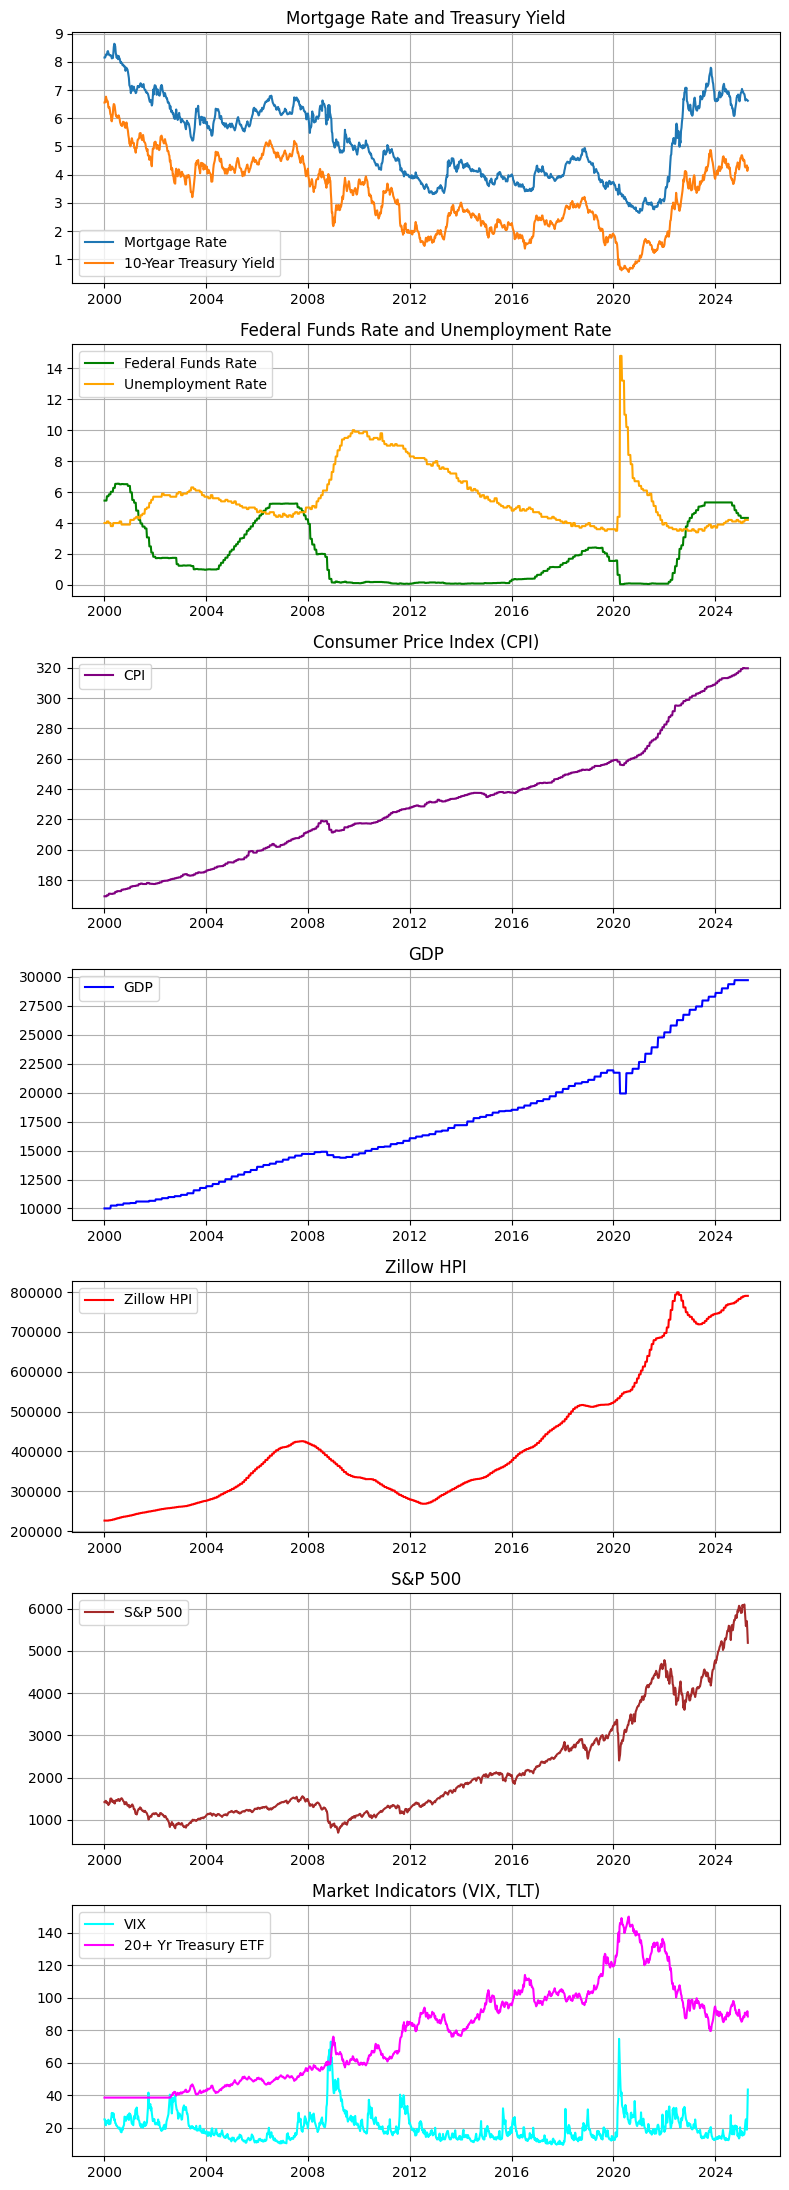

In [22]:
# Create a grid layout for subplots
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 22))

# Plot variables with similar scales together
axes[0].set_title("Mortgage Rate and Treasury Yield")
axes[0].plot(combined.index, combined["MORTGAGE30US"], label="Mortgage Rate")
axes[0].plot(combined.index, combined["DGS10"], label="10-Year Treasury Yield")
axes[0].legend()
axes[0].grid()

axes[1].set_title("Federal Funds Rate and Unemployment Rate")
axes[1].plot(combined.index, combined["FEDFUNDS"], label="Federal Funds Rate", color="green")
axes[1].plot(combined.index, combined["UNRATE"], label="Unemployment Rate", color="orange")
axes[1].legend()
axes[1].grid()

axes[2].set_title("Consumer Price Index (CPI)")
axes[2].plot(combined.index, combined["CPIAUCSL"], label="CPI", color="purple")
axes[2].legend()
axes[2].grid()

axes[3].set_title("GDP")
axes[3].plot(combined.index, combined["GDP"], label="GDP", color="blue")
axes[3].legend()
axes[3].grid()

axes[4].set_title("Zillow HPI")
axes[4].plot(combined.index, combined["Zillow_HPI"], label="Zillow HPI", color="red")
axes[4].legend()
axes[4].grid()

axes[5].set_title("S&P 500")
axes[5].plot(combined.index, combined["^GSPC"], label="S&P 500", color="brown")
axes[5].legend()
axes[5].grid()

axes[6].set_title("Market Indicators (VIX, TLT)")
axes[6].plot(combined.index, combined["^VIX"], label="VIX", color="cyan")
axes[6].plot(combined.index, combined["TLT"], label="20+ Yr Treasury ETF", color="magenta")
axes[6].legend()
axes[6].grid()

plt.tight_layout()
plt.show()

In [23]:
plt.figure(figsize=(14, 6))
combined[["NewsSentiment", "NewsPos", "NewsNeg", "NewsNeu"]].plot()
plt.title("News Sentiment Over Time")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.show()

KeyError: "None of [Index(['NewsSentiment', 'NewsPos', 'NewsNeg', 'NewsNeu'], dtype='object')] are in the [columns]"

<Figure size 1400x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(combined.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Lag Feature Creation

In [ ]:
for lag in [1, 2, 4, 8]:
    combined[f"MORTGAGE30US_{lag}"] = combined["MORTGAGE30US"].shift(lag)

# Save Data Locally

In [ ]:
combined.to_csv("../data/full_mortgage_dataset.csv")